<a href="https://colab.research.google.com/github/yxuan0329/Machine-Learning/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1wZiQGxY7-YWCify3rHvIc4XcJeWCKt_0
!cp PR_HW2_dataset/* .
# !rm -r PR_HW2_dataset

In [ ]:
class FLD:
    def __init__(self):
        self.mean_vectors = []
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

    def fit(self, X, y):
        rows, features = X.shape # 1000, 2
        labels = np.unique(y)
        # Compute mean vectors for each class
        self.mean_vectors = [np.mean(X[y.flatten() == i], axis=0) for i in np.unique(y)]
        
        # Compute Sw (within-class scatter matrix)
        self.sw = np.zeros((features, features))
        for i, mean_vec in enumerate(self.mean_vectors):
            class_sc_mat = np.zeros((features, features))
            for row in X[y.flatten() == i]:
                row, mean_vec = row.reshape(features, 1), mean_vec.reshape(features, 1)
                class_sc_mat += (row - mean_vec).dot((row - mean_vec).T) 
            self.sw += class_sc_mat
        
        # Compute Sb (between-class scatter matrix)
        overall_mean = np.mean(X, axis=0)
        self.sb = np.zeros((features, features))
        for i, mean_vec in enumerate(self.mean_vectors):
            n = X[y.flatten() == i,:].shape[0]
            mean_vec = mean_vec.reshape(features, 1)
            overall_mean = overall_mean.reshape(features, 1)
            self.sb += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
        
        # Compute eigenvalues and eigenvectors of (Sw^-1)(Sb)
        self.w = np.linalg.inv(self.sw).dot(self.sb)
        eig_vals, eig_vecs = np.linalg.eig(self.w)
        print(eig_vals, eig_vecs)

        # Sort eigenvectors in descending order of eigenvalues
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

        # Use the eigenvectors corresponding to the k largest eigenvalues to construct the projection matrix
        self.w = np.hstack((eig_pairs[0][1].reshape(X.shape[1], 1), eig_pairs[1][1].reshape(X.shape[1], 1)))
        self.slope = self.w[1] / self.w[0]
        
    def predict_using_class_mean(self, X, y, X_test):
        y_pred = []
        for x in X_test:
            distances = [np.linalg.norm(x - mv) for mv in self.mean_vectors]
            y_pred.append(np.argmin(distances)) # find shortest distance to the mean
        return np.array(y_pred)

    def predict_using_knn(self, X, y, X_test, k=1):
        # Initialize predicted labels with zeros
        y_pred = np.zeros(y.shape)

        # Compute Euclidean distance between each test point and training data
        distances = np.sqrt(np.sum((X[:, np.newaxis] - X_test)**2, axis=2))

        # Sort distances in ascending order and get the indices of the k-nearest neighbors
        indices = np.argsort(distances, axis=0)[:k]

        # Get the corresponding labels of the k-nearest neighbors and compute the mode
        y_pred = np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=y[indices]))
        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        classes = len(np.unique(y)) # 3
        confusion_matrix = np.zeros((classes, classes))
        confusion_mat = np.zeros((np.unique(y).shape[0], np.unique(y).shape[0]))
        for i in range(len(np.unique(y))):
            for j in range(len(np.unique(y))):
                confusion_mat[i, j] = np.sum((y == i) & (y_pred == j))

        # Plot the confusion matrix
        plt.imshow(confusion_mat, cmap='Blues')
        plt.xticks(ticks=np.arange(len(np.unique(y))), labels=np.unique(y))
        plt.yticks(ticks=np.arange(len(np.unique(y))), labels=np.unique(y))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.colorbar()
        for i in range(len(np.unique(y))):
            for j in range(len(np.unique(y))):
                plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='white')
        plt.show()

    def plot_projection(self, X, y):
        projection = X.dot(self.w)
        color_list = ['blue', 'orange', 'green']
        colors = [color_list[int(label)] for label in y]
        plt.scatter(projection, X)
        print(projection.shape, X.shape)
        plt.xlabel("Fisher's Linear Discriminant")
        plt.yticks([])
        plt.show()

    def accuracy_score(self, y, y_pred):
        return np.mean(y == y_pred)

In [230]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        # self.classes = np.unique(y)
        self.epoch = []
        self.train_loss = []
        self.weights = None

    def fit(self, X, y, batch_size=16, lr=0.001, epochs=100):
        rows, features = X.shape 
        classes = len(np.unique(y))
        self.weights = np.ones((classes, features), dtype=float)
        one_hot_y = self.one_hot(y)

        for epoch in range(epochs):
            for batch in range(len(X)//batch_size):
                y_prob = self.predict(X)
                # print("x shape", X.shape, ", y_prob shape", y_prob.shape, ", one_hot_y shape", one_hot_y.shape) # -> x(1000, 3), y_prob(1000, 3), one_hot_y(1000, 3)
                gradient = np.dot((y_prob - one_hot_y).T, X) / rows # (1000, 3).T * (1000, 3) = (3, 3)
                self.weights = self.weights - lr * gradient  # -> gd(3, 3)  w(3, 3)
                # print("gradient shape", gradient.shape, "weight shape", self.weights.shape)

            if epoch % 2000 == 0:
                train_loss = self.cross_entropy(y, self.predict(X))
                accuracy = self.evaluate(X, y)
                print(f'epoch: {epoch}, weight: {self.weights}, loss: {train_loss}, accuracy: {accuracy}') 
    
    def predict(self, X):
        z = np.dot(X, self.weights.T)
        y_prob = self.softmax(z)
        return y_prob

    def evaluate(self, X, y):
        y_prob = self.predict(X) # (1000, 3)
        y_pred = np.argmax(y_prob, axis=1)
        # for row in range (y_prob.shape[0]):
        #     y_pred[row][0] = np.argmax(y_prob[row]) # maximum probability for each row
        # print(y_prob)
        accuracy = self.accuracy_score(y, y_pred)
        # unique_classes, class_counts = np.unique(y_pred, return_counts=True)
        # for i, cls in enumerate(unique_classes):
        #     print(f"Class {cls}: {class_counts[i]}")
        return accuracy

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)

    def cross_entropy(self, y, probs):
        # Compute one-hot encoded labels
        one_hot_y = self.one_hot(y)

        # Calculate cross-entropy loss
        loss = - np.sum(one_hot_y * np.log(probs)) / y.shape[0]
        return loss


    def one_hot(self, y):
        one_hot_y = np.zeros((len(y), len(np.unique(y)) ))
        one_hot_y[np.arange(len(y)),np.array(y).reshape(-1)] = 1
        return one_hot_y

    def accuracy_score(self, y, y_pred):
        return np.mean(y == y_pred)

    def show_confusion_matrix(self, X, y):
        # Get predicted classes
        y_pred = np.argmax(self.predict(X), axis=1)
        cm = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize=(8, 6))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
        plt.yticks(np.arange(len(np.unique(y))), np.unique(y))
        for i in range(len(np.unique(y))):
            for j in range(len(np.unique(y))):
                plt.text(j, i, str(cm.values[i, j]), ha='center', va='center', color='white')
        plt.show()

# Prepare data for Q1 ~ Q12

In [138]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))
# print(df_train)

In [139]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) # extend one column
y_train = df_train[['Target']].to_numpy().reshape(1000, 1)

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_test = df_test[['Target']].to_numpy().reshape(1000, 1) # .ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 3)
y_train (1000, 1)
X_test (1000, 3)
y_test (1000, 1)


# MultiClass Logistic Regression

In [231]:
# For Q1
lr = 1e-5
batch_size = 1000
epoch = 50000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

epoch: 0, weight: [[1.00000428 1.00001078 0.99999994]
 [0.99998642 0.9999737  1.00000001]
 [1.0000093  1.00001552 1.00000006]], loss: 1.0984784891255681, accuracy: 0.337006
epoch: 2000, weight: [[1.00724398 1.0188285  0.99985851]
 [0.97641772 0.95397341 0.99999305]
 [1.01633831 1.02719809 1.00014844]], loss: 0.8929987104840396, accuracy: 0.336946
epoch: 4000, weight: [[1.01175417 1.03319229 0.99978037]
 [0.95930754 0.91854996 0.99984909]
 [1.02893829 1.04825774 1.00037054]], loss: 0.7734981166602769, accuracy: 0.33673
epoch: 6000, weight: [[1.01407816 1.04443655 0.99978926]
 [0.94685094 0.89041427 0.9995783 ]
 [1.0390709  1.06514918 1.00063243]], loss: 0.6998499798389116, accuracy: 0.336514
epoch: 8000, weight: [[1.01488467 1.05350355 0.99986019]
 [0.93747668 0.86731606 0.99923742]
 [1.04763864 1.07918039 1.00090239]], loss: 0.6509658677681366, accuracy: 0.336298
epoch: 10000, weight: [[1.01466584 1.06100255 0.99996809]
 [0.93014576 0.84781021 0.99886777]
 [1.0551884  1.09118724 1.0011

In [175]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.339


In [176]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.327


In [ ]:
# For Q4
logistic_reg.plot_curve()

AttributeError: ignored

In [ ]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

AttributeError: ignored

# Fisher's Linear Discriminant Analysis

In [ ]:
fld = FLD()

fld.fit(X_train, y_train)

[ 0.13053055 40.83222427] [[-0.88607066 -0.44115384]
 [ 0.46355019 -0.8974315 ]]


In [ ]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [array([-4.17505764,  6.35526804]), array([-9.43385176, -4.87830741]), array([-2.54454008,  7.53144179])]


In [ ]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [ ]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [ ]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384 -0.88607066]
 [-0.8974315   0.46355019]]


FLD using class mean, accuracy:  0.333496


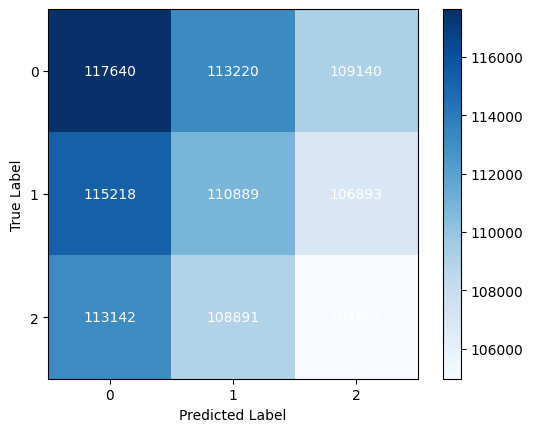

In [ ]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [ ]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.34
FLD using knn (k=2), accuracy:  0.34
FLD using knn (k=3), accuracy:  0.34
FLD using knn (k=4), accuracy:  0.33675
FLD using knn (k=5), accuracy:  0.3348


(1000, 2) (1000, 2)


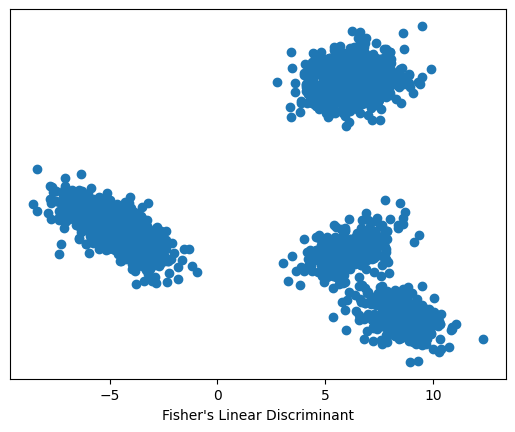

In [ ]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [ ]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
# Data processing

# Refer to section "Prepare data for Q1 ~ Q12"

In [ ]:
# Train your model here

# your_model = ...

In [ ]:
test_pred = your_model.predict(x_test)
print("test_pred shape: ", test_pred.shape)

# Output the csv file

In [ ]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")